
----------- Benchmark Results -----------
Number of nodes: 162
Number of edges: 878
Collision checks performed: 3141
Path found with length: 54.94
Planning time: 1.35 seconds
------------------------------------------


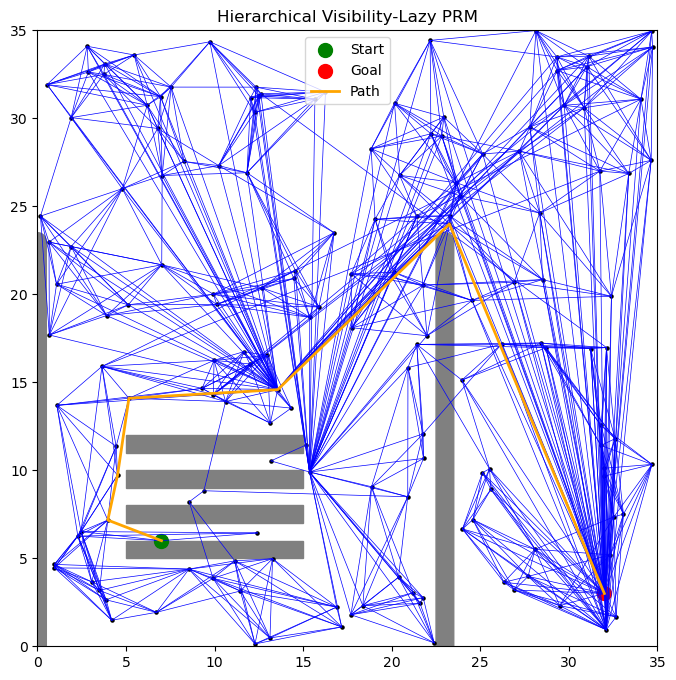

In [ ]:
import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from shapely.geometry import Point, Polygon, LineString
import matplotlib.animation
import sympy
import shapely

# ---------- CONFIGURATION ----------
map_bounds = (0, 35, 0, 35)

obstacles = [ Polygon([(5, 5), (15, 5), (15, 6), (5, 6)]),
            Polygon([(5, 7), (15, 7), (15, 8), (5, 8)]),
            Polygon([(5, 9), (15, 9), (15, 10), (5, 10)]),
            Polygon([(5, 11), (15, 11), (15, 12), (5, 12)]),
            LineString([(0, 0), (0, 23)]).buffer(0.5),
             LineString([(23, 0), (23, 23)]).buffer(0.5), ]
num_regions = 4
samples_per_region = 40
lazy_k_neighbors = 8


# ---------- COLLISION COUNTER ----------
collision_checks = 0


def is_collision(p1, p2, obstacles):
    """Check if the line between p1 and p2 collides with any obstacle."""
    global collision_checks
    collision_checks += 1

    line = LineString([p1, p2])
    for obs in obstacles:
        if line.crosses(obs) or line.within(obs):
            return True
    return False


def sample_free(bounds, obstacles):
    """Sample a collision-free point."""
    minx, maxx, miny, maxy = bounds
    while True:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)
        if not any(obs.contains(point) for obs in obstacles):
            return (x, y)


# ---------- LAZY PRM ----------
def build_lazy_prm(region_bounds, num_samples, k, obstacles):
    G = nx.Graph()
    nodes = []

    for _ in range(num_samples):
        node = sample_free(region_bounds, obstacles)
        G.add_node(node)
        nodes.append(node)

    for node in nodes:
        distances = [(other, np.linalg.norm(np.subtract(node, other)))
                     for other in nodes if other != node]
        distances.sort(key=lambda x: x[1])
        neighbors = distances[:k]

        for neighbor, dist in neighbors:
            G.add_edge(node, neighbor, weight=dist)

    return G


# ---------- VISIBILITY PRM ----------
def build_visibility_prm(nodes, obstacles):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)

        for other in G.nodes:
            if other == node:
                continue

            try:
                _ = nx.shortest_path(G, source=node, target=other)
                continue
            except nx.NetworkXNoPath:
                pass

            if not is_collision(node, other, obstacles):
                dist = np.linalg.norm(np.subtract(node, other))
                G.add_edge(node, other, weight=dist)

    return G


# ---------- HIERARCHICAL PRM ----------
def build_hierarchical_visibility_lazy_prm(global_bounds, num_regions, samples_per_region, k, obstacles):
    minx, maxx, miny, maxy = global_bounds
    midx = (minx + maxx) / 2
    midy = (miny + maxy) / 2

    regions = [
        (minx, midx, miny, midy),  # Bottom-left
        (midx, maxx, miny, midy),  # Bottom-right
        (minx, midx, midy, maxy),  # Top-left
        (midx, maxx, midy, maxy)   # Top-right
    ]

    local_graphs = []
    all_nodes = []

    for region in regions:
        local_graph = build_lazy_prm(region, samples_per_region, k, obstacles)
        local_graphs.append(local_graph)
        all_nodes.extend(local_graph.nodes)

    global_graph = build_visibility_prm(all_nodes, obstacles)

    for local in local_graphs:
        global_graph.add_edges_from(local.edges(data=True))

    return global_graph


# ---------- LAZY VALIDATION ----------
def validate_lazy_path(G, path, obstacles):
    valid = True
    for u, v in zip(path[:-1], path[1:]):
        if is_collision(u, v, obstacles):
            G.remove_edge(u, v)
            valid = False
    return valid


def lazy_shortest_path(G, start, goal, obstacles):
    while True:
        try:
            path = nx.shortest_path(G, source=start, target=goal, weight='weight')
        except nx.NetworkXNoPath:
            return None

        if validate_lazy_path(G, path, obstacles):
            return path


# ---------- PLOTTING ----------
def plot_prm(G, obstacles, start=None, goal=None, path=None):
    plt.figure(figsize=(8, 8))

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray')

    # Plot edges
    for (u, v) in G.edges:
        x = [u[0], v[0]]
        y = [u[1], v[1]]
        plt.plot(x, y, color='blue', linewidth=0.5)

    # Plot nodes
    xs, ys = zip(*G.nodes)
    plt.scatter(xs, ys, color='black', s=5)

    # Plot start and goal
    if start:
        plt.scatter(start[0], start[1], color='green', s=100, label="Start")
    if goal:
        plt.scatter(goal[0], goal[1], color='red', s=100, label="Goal")

    # Plot path
    if path:
        px, py = zip(*path)
        plt.plot(px, py, color='orange', linewidth=2, label="Path")

    plt.xlim(map_bounds[0], map_bounds[1])
    plt.ylim(map_bounds[2], map_bounds[3])
    plt.legend()
    plt.title("Hierarchical Visibility-Lazy PRM")
    plt.show()


# ---------- MAIN ----------
if __name__ == "__main__":
    start_time = time.time()

    collision_checks = 0  # Reset

    # Build graph
    G = build_hierarchical_visibility_lazy_prm(map_bounds, num_regions, samples_per_region, lazy_k_neighbors, obstacles)

    start = (7, 6)
    goal = (32, 3)

    G.add_node(start)
    G.add_node(goal)

    for node in G.nodes:
        if node == start or node == goal:
            continue
        if not is_collision(node, start, obstacles):
            dist = np.linalg.norm(np.subtract(node, start))
            G.add_edge(node, start, weight=dist)
        if not is_collision(node, goal, obstacles):
            dist = np.linalg.norm(np.subtract(node, goal))
            G.add_edge(node, goal, weight=dist)

    # Lazy search
    path = lazy_shortest_path(G, start, goal, obstacles)

    end_time = time.time()
    planning_time = end_time - start_time

    # Compute path length
    path_length = 0
    if path:
        for u, v in zip(path[:-1], path[1:]):
            path_length += np.linalg.norm(np.subtract(u, v))

    # ---------- BENCHMARK ----------
    print("\n----------- Benchmark Results -----------")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Collision checks performed: {collision_checks}")
    if path:
        print(f"Path found with length: {path_length:.2f}")
    else:
        print("No valid path found.")
    print(f"Planning time: {planning_time:.2f} seconds")
    print("------------------------------------------")

    # ---------- PLOT ----------
    plot_prm(G, obstacles, start, goal, path)

    import matplotlib.animation as animation


def animate_prm(G, obstacles, start=None, goal=None, path=None, save_as=None):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot obstacles
    for obs in obstacles:
        if isinstance(obs, Polygon):
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')
        else:
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')

    ax.set_xlim(map_bounds[0], map_bounds[1])
    ax.set_ylim(map_bounds[2], map_bounds[3])
    ax.set_title("Hierarchical Visibility-Lazy PRM Animation")

    # Prepare data for edges
    edges = list(G.edges)

    edge_lines = []
    for (u, v) in edges:
        line, = ax.plot([], [], color='blue', linewidth=0.5)
        edge_lines.append(line)

    # Nodes
    xs, ys = zip(*G.nodes)
    ax.scatter(xs, ys, color='black', s=5)

    # Start and goal
    if start:
        ax.scatter(start[0], start[1], color='green', s=100, label="Start")
    if goal:
        ax.scatter(goal[0], goal[1], color='red', s=100, label="Goal")

    # Path line
    if path:
        path_line, = ax.plot([], [], color='orange', linewidth=2, label='Path')
    else:
        path_line = None

    ax.legend()

    total_frames = len(edges) + (len(path) - 1 if path else 0)

    def update(frame):
        if frame < len(edges):
            u, v = edges[frame]
            edge_lines[frame].set_data([u[0], v[0]], [u[1], v[1]])
        else:
            if path and path_line:
                idx = frame - len(edges) + 1
                if idx <= len(path):
                    px, py = zip(*path[:idx])
                    path_line.set_data(px, py)

        return edge_lines + ([path_line] if path_line else [])

    ani = animation.FuncAnimation(
        fig, update, frames=total_frames + 10,
        interval=50, blit=True, repeat=False
    )

plt.show()



In [13]:
import matplotlib.animation as animation


def animate_prm(G, obstacles, start=None, goal=None, path=None, save_as=None):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot obstacles
    for obs in obstacles:
        if isinstance(obs, Polygon):
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')
        else:
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')

    ax.set_xlim(map_bounds[0], map_bounds[1])
    ax.set_ylim(map_bounds[2], map_bounds[3])
    ax.set_title("Hierarchical Visibility-Lazy PRM Animation")

    # Prepare data for edges
    edges = list(G.edges)

    edge_lines = []
    for (u, v) in edges:
        line, = ax.plot([], [], color='blue', linewidth=0.5)
        edge_lines.append(line)

    # Nodes
    xs, ys = zip(*G.nodes)
    ax.scatter(xs, ys, color='black', s=5)

    # Start and goal
    if start:
        ax.scatter(start[0], start[1], color='green', s=100, label="Start")
    if goal:
        ax.scatter(goal[0], goal[1], color='red', s=100, label="Goal")

    # Path line
    if path:
        path_line, = ax.plot([], [], color='orange', linewidth=2, label='Path')
    else:
        path_line = None

    ax.legend()

    total_frames = len(edges) + (len(path) - 1 if path else 0)

    def update(frame):
        if frame < len(edges):
            u, v = edges[frame]
            edge_lines[frame].set_data([u[0], v[0]], [u[1], v[1]])
        else:
            if path and path_line:
                idx = frame - len(edges) + 1
                if idx <= len(path):
                    px, py = zip(*path[:idx])
                    path_line.set_data(px, py)

        return edge_lines + ([path_line] if path_line else [])

    ani = animation.FuncAnimation(
        fig, update, frames=total_frames + 10,
        interval=50, blit=True, repeat=False
    )

  
    plt.show()


In [ ]:
import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from shapely.geometry import Point, Polygon, LineString
import testEnvironments as ts
from IPLazyPRM import LazyPRM
from IPVISLazyPRM import lazyPRMVisualize


# ---------- CONFIGURATION ----------
map_bounds = ts
envs = ts

obstacles = envs
num_regions = 4
samples_per_region = 40


# ---------- COLLISION COUNTER ----------
collision_checks = 0


def is_collision(p1, p2, obstacles):
    """Check if the line between p1 and p2 collides with any obstacle."""
    global collision_checks
    collision_checks += 1

    line = LineString([p1, p2])
    for obs in obstacles:
        if line.crosses(obs) or line.within(obs):
            return True
    return False


def sample_free(bounds, obstacles):
    """Sample a collision-free point."""
    minx, maxx, miny, maxy = bounds
    while True:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        point = Point(x, y)
        if not any(obs.contains(point) for obs in obstacles):
            return (x, y)


# ---------- LAZY PRM ----------
lazyConfig = dict()
lazyConfig["initialRoadmapSize"] = 10 # number of nodes of first roadmap
lazyConfig["updateRoadmapSize"]  = 3 # number of nodes to add if there is no connection from start to end
lazyConfig["kNearest"] = 5 # number of nodes to connect to during setup
lazyConfig["maxIterations"] = 30 # number of nodes to connect to during setup

for benchmark in ts.benchList:
    try:
        fig_local = plt.figure(figsize=(10,10))
        ax = fig_local.add_subplot(1,1,1)
        vis = LazyPRM(benchmark.collisionChecker)
        solution = vis.planPath(benchmark.startList, benchmark.goalList, lazyConfig)
        title = benchmark.name
        if solution == []:
            title += " (No path found!)"
        title += "\n Assumed complexity level " + str(benchmark.level)
        ax.set_title(title)
        lazyPRMVisualize(vis, solution, ax=ax, nodeSize=50)
    except Exception as e:
        print("ERROR: ",benchmark.name, e)

#-------------Lazy Interraction--------------
@interact(initialRoadmapSize=(5, 1000), updateRoadmapSize=(20,100), kNearest=(3,10), maxIterations=(10,100), __manual=True)
def test(initialRoadmapSize=6, updateRoadmapSize=30, kNearest=5, maxIterations=50):
    mystart = [[1,20]]
    myend = [[20,1]]
    print("test",initialRoadmapSize)
    environment = benchmark.collisionChecker
    lazy = LazyPRM(environment)
    lazyConfig = dict()
    lazyConfig["initialRoadmapSize"] = initialRoadmapSize # number of nodes of first roadmap
    lazyConfig["updateRoadmapSize"]  = updateRoadmapSize # number of nodes to add if there is no connection from start to end
    lazyConfig["kNearest"] = 5 #kNearest number of nodes to connect to during setup
    lazyConfig["maxIterations"] = maxIterations # number of nodes to connect to during setup

    #environment.resetCounter()
    
    solution = lazy.planPath(mystart, myend, lazyConfig)

    fig_local = plt.figure(figsize=(10,10))
    ax = fig_local.add_subplot(1,1,1)
    lazyPRMVisualize(lazy, solution, ax=ax)
 
"""
# ---------- VISIBILITY PRM ----------
def build_visibility_prm(nodes, obstacles):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)

        for other in G.nodes:
            if other == node:
                continue

            try:
                _ = nx.shortest_path(G, source=node, target=other)
                continue
            except nx.NetworkXNoPath:
                pass

            if not is_collision(node, other, obstacles):
                dist = np.linalg.norm(np.subtract(node, other))
                G.add_edge(node, other, weight=dist)

    return G


# ---------- HIERARCHICAL PRM ----------
def build_hierarchical_visibility_lazy_prm(global_bounds, num_regions, samples_per_region, k, obstacles):
    minx, maxx, miny, maxy = global_bounds
    midx = (minx + maxx) / 2
    midy = (miny + maxy) / 2

    regions = [
        (minx, midx, miny, midy),  # Bottom-left
        (midx, maxx, miny, midy),  # Bottom-right
        (minx, midx, midy, maxy),  # Top-left
        (midx, maxx, midy, maxy)   # Top-right
    ]

    local_graphs = []
    all_nodes = []

    for region in regions:
        local_graph = build_lazy_prm(region, samples_per_region, k, obstacles)
        local_graphs.append(local_graph)
        all_nodes.extend(local_graph.nodes)

    global_graph = build_visibility_prm(all_nodes, obstacles)

    for local in local_graphs:
        global_graph.add_edges_from(local.edges(data=True))

    return global_graph
"""

NameError: name 'limits' is not defined

In [2]:
# --- Hierarchical Path Planning System ---

import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib.animation as animation
from shapely.geometry import Point, Polygon, LineString
from shapely.affinity import rotate
from testEnvironments import TestEnvironments
from IPEnvironment import CollisionChecker
import time

# === GLOBAL SETTINGS ===
MAX_SAMPLES = 300     # Maximum number of samples in PRM
NEIGHBOR_RADIUS = 5.0 # Max connection radius for PRM

# === SETUP ENVIRONMENTS ===
all_envs = TestEnvironments().get_all_scenes()
scene_names = list(all_envs.keys())

# === FIGURE SETUP ===
fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.25, bottom=0.25)

# === SLIDER AXES ===
ax_env = plt.axes([0.25, 0.15, 0.65, 0.03])
ax_dof = plt.axes([0.25, 0.10, 0.65, 0.03])

# === SLIDERS ===
env_slider = Slider(ax_env, 'Environment', 0, len(scene_names)-1, valinit=0, valstep=1)
dof_slider = Slider(ax_dof, 'DOF', 1, 6, valinit=1, valstep=1)

# === FUNCTION: Generate random free sample ===
def random_sample(limits):
    return np.array([
        random.uniform(*limits[0]),
        random.uniform(*limits[1])
    ])

# === FUNCTION: Collision check for path ===
def collision_free_path(p1, p2, checker):
    line = LineString([p1, p2])
    return not checker.collides(line)

# === VISIBILITY PRM (GLOBAL PLANNER) ===
def visibility_prm(scene, checker):
    G = nx.Graph()
    nodes = []
    start = scene["start"].centroid
    goal = scene["goal"].centroid
    nodes.extend([start, goal])

    # Sample random free nodes
    while len(nodes) < MAX_SAMPLES:
        sample = random_sample(checker.limits)
        point = Point(sample)
        if not checker.collides(point):
            nodes.append(point)

    # Add nodes to graph
    for i, pi in enumerate(nodes):
        G.add_node(i, point=pi)

    # Connect visible nodes
    for i in G.nodes:
        for j in G.nodes:
            if i != j:
                pi, pj = G.nodes[i]['point'], G.nodes[j]['point']
                if collision_free_path((pi.x, pi.y), (pj.x, pj.y), checker):
                    G.add_edge(i, j, weight=pi.distance(pj))

    return G

# === LAZY PRM (LOCAL PLANNER) ===
def lazy_prm(start_point, goal_point, checker):
    G = nx.Graph()
    nodes = [start_point, goal_point]

    while len(nodes) < 50:
        sample = random_sample(checker.limits)
        point = Point(sample)
        if not checker.collides(point):
            nodes.append(point)

    for i, pi in enumerate(nodes):
        G.add_node(i, point=pi)

    for i in G.nodes:
        for j in G.nodes:
            if i != j:
                pi, pj = G.nodes[i]['point'], G.nodes[j]['point']
                G.add_edge(i, j, weight=pi.distance(pj))  # Lazy: don't validate yet

    try:
        path = nx.shortest_path(G, source=0, target=1, weight='weight')
    except nx.NetworkXNoPath:
        return []

    valid_path = [path[0]]
    for i in range(1, len(path)):
        p1 = G.nodes[path[i-1]]['point']
        p2 = G.nodes[path[i]]['point']
        if collision_free_path((p1.x, p1.y), (p2.x, p2.y), checker):
            valid_path.append(path[i])
        else:
            return []  # Invalid edge found

    return [G.nodes[i]['point'] for i in valid_path]

# === FORWARD KINEMATICS FOR PLANAR ROBOT ===
def get_robot_links(dof, config):
    length = 1.0
    x, y, theta = config[0], config[1], config[2:]
    points = [(x, y)]
    angle = 0
    for i in range(dof-1):
        angle += theta[i]
        x += length * math.cos(angle)
        y += length * math.sin(angle)
        points.append((x, y))
    return points

# === ANIMATION ===
def animate_path(ax, path_points):
    line, = ax.plot([], [], 'g-', lw=2)
    dots, = ax.plot([], [], 'go')

    def init():
        line.set_data([], [])
        dots.set_data([], [])
        return line, dots

    def update(frame):
        xs = [p.x for p in path_points[:frame+1]]
        ys = [p.y for p in path_points[:frame+1]]
        line.set_data(xs, ys)
        dots.set_data(xs, ys)
        return line, dots

    ani = animation.FuncAnimation(fig, update, frames=len(path_points),
                                  init_func=init, interval=100, blit=True)
    return ani

# === DRAW SCENE ===
def draw_scene(scene, title, path_points=None, G=None):
    ax.clear()
    checker = CollisionChecker(scene)
    checker.drawObstacles(ax)
    if "start" in scene:
        center = scene["start"].centroid
        ax.plot(center.x, center.y, 'bo', markersize=10, label="Start")
    if "goal" in scene:
        center = scene["goal"].centroid
        ax.plot(center.x, center.y, 'ro', markersize=10, label="Goal")

    if G:
        for (i, j) in G.edges:
            pi, pj = G.nodes[i]['point'], G.nodes[j]['point']
            ax.plot([pi.x, pj.x], [pi.y, pj.y], 'gray', linewidth=0.5)

    if path_points:
        animate_path(ax, path_points)

    ax.set_xlim(0, 23)
    ax.set_ylim(0, 23)
    ax.set_aspect('equal')
    ax.legend()
    ax.set_title(title)
    ax.grid(True)
    fig.canvas.draw_idle()

# === HIERARCHICAL PLANNER ===
def hierarchical_plan(scene, checker):
    global_graph = visibility_prm(scene, checker)
    try:
        coarse_path = nx.shortest_path(global_graph, source=0, target=1, weight='weight')
    except nx.NetworkXNoPath:
        return [], global_graph

    full_path = []
    for i in range(len(coarse_path) - 1):
        p1 = global_graph.nodes[coarse_path[i]]['point']
        p2 = global_graph.nodes[coarse_path[i + 1]]['point']
        local_segment = lazy_prm(p1, p2, checker)
        if not local_segment:
            return [], global_graph  # fail if local connection fails
        if full_path:
            full_path.extend(local_segment[1:])  # avoid duplicate
        else:
            full_path.extend(local_segment)
    return full_path, global_graph

# === MAIN UPDATE ===
def update(val):
    env_index = int(env_slider.val)
    dof = int(dof_slider.val)
    scene = all_envs[scene_names[env_index]]
    checker = CollisionChecker(scene)
    full_path, G = hierarchical_plan(scene, checker)
    title = f"Scene: {scene_names[env_index]} | DOF: {dof}"
    draw_scene(scene, title, path_points=full_path, G=G)

# === INITIAL DRAW ===
update(None)

# === SLIDER CALLBACK ===
env_slider.on_changed(update)
dof_slider.on_changed(update)

# === SHOW ===
plt.show()


RecursionError: maximum recursion depth exceeded

In [ ]:
%matplotlib widget
import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from shapely.geometry import Point, Polygon, LineString
import matplotlib.animation as animation
import shapely
import importlib
import environments  # You must have environments.py file with environment definitions
from matplotlib.widgets import Slider, Button
import matplotlib
matplotlib.use('TkAgg')  # Use 'QtAgg' or 'WXAgg' if needed
from IPython.display import HTML
# --------------------------------------------------
# Utility Functions
# --------------------------------------------------
def is_in_collision(p, obstacles):
    point = Point(p)
    return any(obstacle.contains(point) for obstacle in obstacles)

def edge_collision(p1, p2, obstacles):
    line = LineString([p1, p2])
    return any(obstacle.intersects(line) for obstacle in obstacles)

# --------------------------------------------------
# Visibility PRM
# --------------------------------------------------
def visibility_prm(start, goal, obstacles, n_samples=200, radius=20):
    G = nx.Graph()
    milestones = [start, goal]

    while len(milestones) < n_samples:
        p = (random.uniform(0, 100), random.uniform(0, 100))
        if not is_in_collision(p, obstacles):
            milestones.append(p)

    for i, m1 in enumerate(milestones):
        for j in range(i + 1, len(milestones)):
            m2 = milestones[j]
            if np.linalg.norm(np.array(m1) - np.array(m2)) < radius:
                if not edge_collision(m1, m2, obstacles):
                    G.add_edge(m1, m2, weight=np.linalg.norm(np.array(m1) - np.array(m2)))

    return G

# --------------------------------------------------
# Lazy PRM (Local Planner)
# --------------------------------------------------
def lazy_prm(G, start, goal, obstacles):
    try:
        path = nx.shortest_path(G, source=start, target=goal, weight='weight')
    except nx.NetworkXNoPath:
        return None

    valid_path = [path[0]]
    for i in range(1, len(path)):
        if edge_collision(path[i-1], path[i], obstacles):
            return None  # Replan needed
        valid_path.append(path[i])

    return valid_path

# --------------------------------------------------
# Hierarchical Planner
# --------------------------------------------------
def hierarchical_prm(start, goal, obstacles):
    G = visibility_prm(start, goal, obstacles)
    path = lazy_prm(G, start, goal, obstacles)
    return G, path

# --------------------------------------------------
# Benchmarking
# --------------------------------------------------
def benchmark(envs):
    results = []
    for env in envs:
        start, goal, obstacles = env['start'], env['goal'], env['obstacles']
        t0 = time.time()
        G, path = hierarchical_prm(start, goal, obstacles)
        t1 = time.time()
        results.append({'path': path, 'graph': G, 'time': t1 - t0, 'start': start, 'goal': goal, 'obstacles': obstacles})
    return results

# --------------------------------------------------
# Animation
# --------------------------------------------------
def animate_path(result):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # Draw obstacles
    for obs in result['obstacles']:
        x, y = obs.exterior.xy
        ax.fill(x, y, color='gray')

    # Draw roadmap edges
    for edge in result['graph'].edges:
        xs = [edge[0][0], edge[1][0]]
        ys = [edge[0][1], edge[1][1]]
        ax.plot(xs, ys, 'lightblue', linewidth=0.5)

    # No path found
    if result['path'] is None:
        ax.set_title("No path found")
        plt.show()
        return

    points = np.array(result['path'])
    line, = ax.plot([], [], 'r-', linewidth=2)
    marker, = ax.plot([], [], 'ro')  # moving point

    def update(i):
        line.set_data(points[:i+1, 0], points[:i+1, 1])
        marker.set_data(points[i, 0], points[i, 1])
        return line, marker

    ani = animation.FuncAnimation(fig, update, frames=len(points), interval=300, repeat=False)

    # 🔥 Keep reference alive explicitly
    plt.show(block=True)
    return ani  # must be assigned externally



# --------------------------------------------------
# Interactive Slider to View Multiple Environments
# --------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib.animation as animation

def interactive_plot(results):
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.3)
    ax_slider = plt.axes([0.2, 0.15, 0.6, 0.03])
    ax_button = plt.axes([0.4, 0.05, 0.2, 0.06])

    slider = Slider(ax_slider, 'Environment', 0, len(results) - 1, valinit=0, valstep=1)
    button = Button(ax_button, 'Animate')

    ani_container = [None]

    def plot_result(index):
        ax.clear()
        result = results[index]

        for obs in result['obstacles']:
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')

        for edge in result['graph'].edges:
            xs = [edge[0][0], edge[1][0]]
            ys = [edge[0][1], edge[1][1]]
            ax.plot(xs, ys, 'lightblue', linewidth=0.5)

        if result['path']:
            xs, ys = zip(*result['path'])
            ax.plot(xs, ys, 'r-', linewidth=2)
            ax.plot(*result['start'], 'go')
            ax.plot(*result['goal'], 'ro')
        else:
            ax.set_title("No path found")

        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        ax.set_title(f"Env {index} - Time: {result['time']:.2f}s")
        fig.canvas.draw_idle()

    def animate_current(event):
        index = int(slider.val)
        result = results[index]

        if not result['path']:
            print("No path to animate.")
            return

        points = np.array(result['path'])
        line, = ax.plot([], [], 'r-', linewidth=2)
        marker, = ax.plot([], [], 'ro')

        def update(i):
            line.set_data(points[:i+1, 0], points[:i+1, 1])
            marker.set_data(points[i, 0], points[i, 1])
            return line, marker

        ani_container[0] = animation.FuncAnimation(
            fig, update, frames=len(points), interval=300, repeat=False
        )
        fig.canvas.draw_idle()

    def on_slider_change(val):
        plot_result(int(val))

    slider.on_changed(on_slider_change)
    button.on_clicked(animate_current)

    plot_result(0)
    plt.show()



# --------------------------------------------------
# Main Execution
# --------------------------------------------------
if __name__ == "__main__":
    envs = environments.get_environments()  # You must define this in environments.py
    results = benchmark(envs)
    interactive_plot(results)
    for result in results:
        ani = animate_path(results[0])  # or whichever result you're animating



Traceback (most recent call last):
  File "c:\Users\mertb\anaconda3\Lib\site-packages\matplotlib\cbook.py", line 298, in process
    func(*args, **kwargs)
  File "c:\Users\mertb\anaconda3\Lib\site-packages\matplotlib\animation.py", line 892, in _start
    self._init_draw()
  File "c:\Users\mertb\anaconda3\Lib\site-packages\matplotlib\animation.py", line 1727, in _init_draw
    self._draw_frame(frame_data)
  File "c:\Users\mertb\anaconda3\Lib\site-packages\matplotlib\animation.py", line 1746, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mertb\AppData\Local\Temp\ipykernel_10324\4069721676.py", line 186, in update
    marker.set_data(points[i, 0], points[i, 1])
  File "c:\Users\mertb\anaconda3\Lib\site-packages\matplotlib\lines.py", line 665, in set_data
    self.set_xdata(x)
  File "c:\Users\mertb\anaconda3\Lib\site-packages\matplotlib\lines.py", line 1289, in set_xdata
    raise 

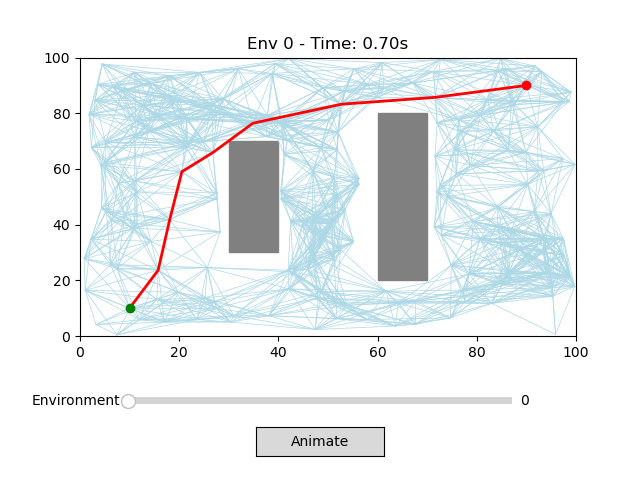

RuntimeError: x must be a sequence

TypeError: list indices must be integers or slices, not str

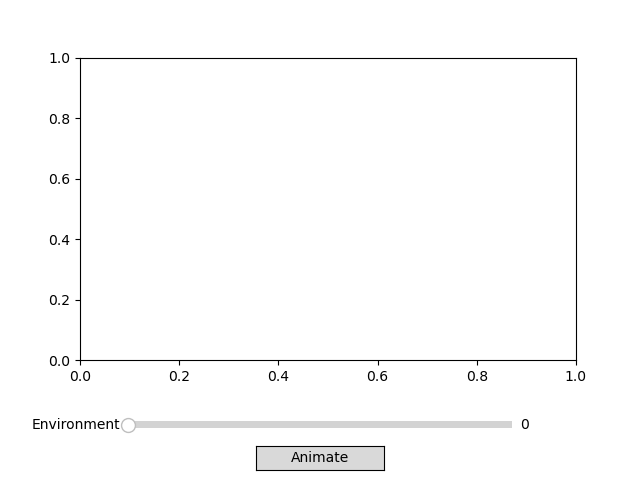

In [ ]:
# HIERARCHICAL PRM PLANNER: Visibility PRM (global) + Lazy PRM (local)
# Jupyter Notebook Compatible Version with Slider + Animation Button

%matplotlib widget

import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from shapely.geometry import Point, Polygon, LineString
import matplotlib.animation as animation
import shapely
import environments  # You must define get_environments() in this file
from matplotlib.widgets import Slider, Button

# --------------------------------------------------
# Utility Functions
# --------------------------------------------------
def is_in_collision(p, obstacles):
    point = Point(p)
    return any(obstacle.contains(point) for obstacle in obstacles)

def edge_collision(p1, p2, obstacles):
    line = LineString([p1, p2])
    return any(obstacle.intersects(line) for obstacle in obstacles)

# --------------------------------------------------
# Visibility PRM
# --------------------------------------------------
def visibility_prm(start, goal, obstacles, n_samples=200, radius=20):
    G = nx.Graph()
    milestones = [start, goal]

    while len(milestones) < n_samples:
        p = (random.uniform(0, 100), random.uniform(0, 100))
        if not is_in_collision(p, obstacles):
            milestones.append(p)

    for i, m1 in enumerate(milestones):
        for j in range(i + 1, len(milestones)):
            m2 = milestones[j]
            if np.linalg.norm(np.array(m1) - np.array(m2)) < radius:
                if not edge_collision(m1, m2, obstacles):
                    G.add_edge(m1, m2, weight=np.linalg.norm(np.array(m1) - np.array(m2)))

    return G

# --------------------------------------------------
# Lazy PRM (Local Planner)
# --------------------------------------------------
def lazy_prm(G, start, goal, obstacles):
    try:
        path = nx.shortest_path(G, source=start, target=goal, weight='weight')
    except nx.NetworkXNoPath:
        return None

    valid_path = [path[0]]
    for i in range(1, len(path)):
        if edge_collision(path[i-1], path[i], obstacles):
            return None
        valid_path.append(path[i])

    return valid_path

# --------------------------------------------------
# Hierarchical Planner
# --------------------------------------------------
def hierarchical_prm(start, goal, obstacles):
    G = visibility_prm(start, goal, obstacles)
    path = lazy_prm(G.copy(), start, goal, obstacles)
    return G, path

# --------------------------------------------------
# Benchmarking
# --------------------------------------------------
def benchmark(envs):
    results = []
    for env in envs:
        start, goal, obstacles = env['start'], env['goal'], env['obstacles']
        t0 = time.time()
        G, path = hierarchical_prm(start, goal, obstacles)
        t1 = time.time()
        results.append({'path': path, 'graph': G, 'time': t1 - t0, 'start': start, 'goal': goal, 'obstacles': obstacles})
    return results

# --------------------------------------------------
# Interactive Slider and Animation Button
# --------------------------------------------------
def interactive_plot(results):
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.25)
    ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])
    ax_button = plt.axes([0.4, 0.02, 0.2, 0.05])

    slider = Slider(ax_slider, 'Environment', 0, len(results) - 1, valinit=0, valstep=1)
    button = Button(ax_button, 'Animate')

    ani_container = [None]  # keep reference to prevent garbage collection

    def plot_result(index):
        ax.clear()
        result = results[index]

        for obs in result['obstacles']:
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')

        for edge in result['graph'].edges:
            xs = [edge[0][0], edge[1][0]]
            ys = [edge[0][1], edge[1][1]]
            ax.plot(xs, ys, 'lightblue', linewidth=0.5)

        if result['path']:
            xs, ys = zip(*result['path'])
            ax.plot(xs, ys, 'r-', linewidth=2)
            ax.plot(result['start'][0], result['start'][1], 'go')
            ax.plot(result['goal'][0], result['goal'][1], 'ro')
            ax.set_title(f"Env {index} - Time: {result['time']:.2f}s")
        else:
            ax.set_title("No path found")

        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        fig.canvas.draw_idle()

    def animate_result(result):
        if not result['path']:
            print("No path found for animation.")
            return

    points = np.array(result['path'])
    if not isinstance(points, np.ndarray) or points.ndim != 2 or points.shape[0] < 2:
        print("Invalid path for animation.")
        return

    line, = ax.plot([], [], 'r-', linewidth=2)
    marker, = ax.plot([], [], 'ro')

    def update(i):
        if i < len(points):
            line.set_data(points[:i+1, 0], points[:i+1, 1])
            marker.set_data(points[i, 0], points[i, 1])
        return line, marker

    ani = animation.FuncAnimation(fig, update, frames=len(points), interval=300, repeat=False)
    ani_container[0] = ani
    fig.canvas.draw_idle()




# --------------------------------------------------
# Main Execution (Jupyter-safe)
# --------------------------------------------------

envs = environments.get_environments()  # must return list of dicts with start, goal, obstacles
results = benchmark(envs)
interactive_plot(results)
